- Shuffle X
- Do not load the entire dataset -> Store info in df and use generator
- Data augmentation (imgaug)
    - rotate
    - brightness

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
import keras.layers as L
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils.np_utils import to_categorical

import os

Using TensorFlow backend.


In [3]:
pd.read_csv('10-monkey-species/monkey_labels.txt')

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
TRAIN_PATH = '10-monkey-species/training/training/'
TEST_PATH = '10-monkey-species/validation/validation/'
MONKEY_FOL = os.listdir(TRAIN_PATH)
IMG_SIZE = 128

In [5]:
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [6]:
X = []
y = []
for folder in MONKEY_FOL:
    folder_path = os.path.join(TRAIN_PATH, folder)
    img_name = os.listdir(folder_path)
    monkey_type = np.int(folder[1])
    X += [read_image(os.path.join(folder_path, img))
          for img in img_name]    
    y += [monkey_type] * len(img_name)
        
X = np.array(X)
y = np.array(y)

In [7]:
X.shape, y.shape

((1098, 128, 128), (1098,))

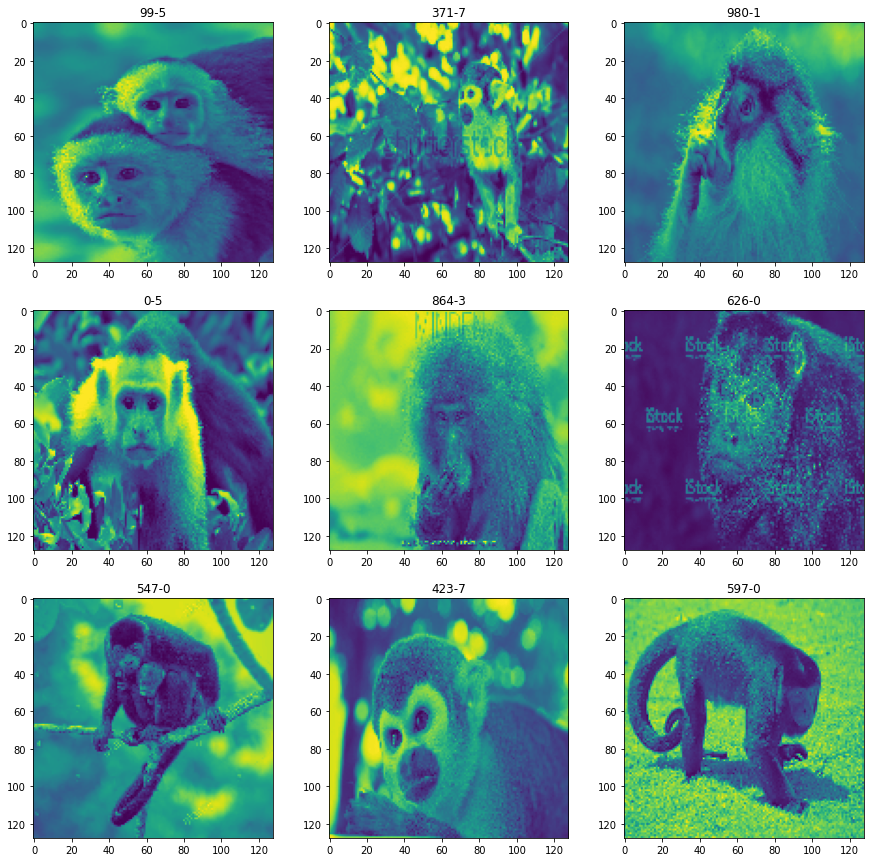

In [8]:
sample = np.random.randint(0, len(X), 9)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        index = i*3+j
        axs[i, j].imshow(X[sample[index]])
        axs[i, j].set_title('%d-%d' % (sample[index], y[sample[index]]))

In [9]:
y = to_categorical(y)
Xt, Xv, yt, yv = train_test_split(X, y)
Xt.shape, Xv.shape, yt.shape, yv.shape

((823, 128, 128), (275, 128, 128), (823, 10), (275, 10))

In [10]:
def data_augmentation(X, y):
    Xh = np.array([cv2.flip(img, 1) for img in X])
    X_new = np.concatenate((X, Xh))
    y_new = np.concatenate((y, y))
    return X_new, y_new

In [11]:
Xt, yt = data_augmentation(Xt, yt)
Xt = Xt.reshape(Xt.shape[0], Xt.shape[1], Xt.shape[2], 1)
Xv = Xv.reshape(Xv.shape[0], Xv.shape[1], Xv.shape[2], 1)
Xt.shape, Xv.shape, yt.shape, yv.shape

((1646, 128, 128, 1), (275, 128, 128, 1), (1646, 10), (275, 10))

In [12]:
model = Sequential([
    L.Conv2D(16, (3, 3), activation='relu', input_shape = (IMG_SIZE, IMG_SIZE, 1)),
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(32, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(64, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Conv2D(128, (3, 3), activation='relu'), 
    L.MaxPooling2D(pool_size = (2, 2)), 
    L.Flatten(),
    L.Dense(units = 128, activation = 'relu'),
    L.Dense(units = 64, activation = 'relu'), 
    L.Dense(units = 32, activation = 'relu'),
    L.Dense(10, activation='softmax'),
])

checkpoint = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(Xt, yt, epochs=20, batch_size=8, validation_data=(Xv, yv), callbacks=[checkpoint])

Train on 1646 samples, validate on 275 samples
Epoch 1/20
1646/1646 [==============================] - 11s 7ms/step - loss: 0.3453 - accuracy: 0.8974 - val_loss: 0.3055 - val_accuracy: 0.9000
Epoch 2/20
1646/1646 [==============================] - 9s 6ms/step - loss: 0.2976 - accuracy: 0.8998 - val_loss: 0.2909 - val_accuracy: 0.9004
Epoch 3/20
1646/1646 [==============================] - 10s 6ms/step - loss: 0.2851 - accuracy: 0.9010 - val_loss: 0.2811 - val_accuracy: 0.9022
Epoch 4/20
1646/1646 [==============================] - 9s 5ms/step - loss: 0.2711 - accuracy: 0.9030 - val_loss: 0.2834 - val_accuracy: 0.9004
Epoch 5/20
1646/1646 [==============================] - 9s 5ms/step - loss: 0.2544 - accuracy: 0.9078 - val_loss: 0.2736 - val_accuracy: 0.9025
Epoch 6/20
1646/1646 [==============================] - 9s 5ms/step - loss: 0.2248 - accuracy: 0.9148 - val_loss: 0.2968 - val_accuracy: 0.8982
Epoch 7/20
1646/1646 [==============================] - 9s 6ms/step - loss: 0.2040 - ac

In [13]:
model = load_model('model.hdf5')

In [14]:
score_t = model.evaluate(Xt, yt, batch_size=64)
score_v = model.evaluate(Xv, yv, batch_size=64)
score_t[1], score_v[1]

275/275 [==============================] - 0s 1ms/step


(0.9120898842811584, 0.9025454521179199)

In [15]:
X_test = []
y_test = []
for folder in MONKEY_FOL:
    folder_path = os.path.join(TEST_PATH, folder)
    img_name = os.listdir(folder_path)
    monkey_type = np.int(folder[1])
    X_test += [read_image(os.path.join(folder_path, img))
          for img in img_name]    
    y_test += [monkey_type] * len(img_name)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = to_categorical(y_test)
X_test.shape, y_test.shape

((272, 128, 128, 1), (272, 10))

In [16]:
model.evaluate(X_test, y_test, batch_size=64)[1]

272/272 [==============================] - 0s 1ms/step


0.9066176414489746